In this notebook we will continue with our integration, this time using moscot library to translate our ATAC-seq dataset onto RNA-seq space and transfer RNA-seq labels to ATAC-seq dataset. You can find the link to the previous notebook below:

## Pre-processing

In [ ]:
!pip install scanpy
!pip install scvi-tools
!pip install scikit-learn
!pip install moscot
!pip install igraph
!pip install leidenalg
!pip install cellrank
!pip install plotly

In [ ]:
import warnings
import os


import anndata as ad
import pandas as pd
import scanpy as sc

import numpy as np

from moscot.problems.time import TemporalProblem

import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel
import warnings

import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.cross_modality import TranslationProblem


import scipy
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt


warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

Let's calculate LSI for ATAC-seq and PCA for RNA-seq dataset. The reason that we choose different types of dimensioality reduction is because ATAC-seq data is binary data that is typically very sparse, with many zeros indicating regions of the genome that are not accessible. LSI, being a technique originally designed for text data (which is similarly sparse), is suitable for reducing the dimensionality of such data type. On the other hand, PCA is generally more suitable for RNA-seq due to its capability to deal with continuous and dense gene expression data.

In [ ]:
import scanpy as sc

def add_pca_to_rna_seq(adata):
    sc.pp.filter_genes(adata, min_cells=3)  # Filter out genes that are detected in fewer than 3 cells
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var['highly_variable']]
    sc.tl.pca(adata, svd_solver='arpack')
    return adata


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import numpy as np

def add_lsi_to_atac_seq(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # Normalize the total counts to 10,000 per cell
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log transform the data
    sc.pp.log1p(adata)
    # Applying TruncatedSVD, which is similar to PCA
    svd = TruncatedSVD(n_components=50)
    X_reduced = svd.fit_transform(adata.X)
    # Normalize the SVD components using L2 norm
    normalizer = Normalizer(norm='l2')
    X_normalized = normalizer.fit_transform(X_reduced)
    # Save the result back to obsm
    adata.obsm['ATAC_lsi_l2_norm'] = X_normalized
    return adata


In [ ]:
scrna_path = "zf_atlas_full_v4_release.h5ad"
rna_seq_data = sc.read_h5ad(scrna_path)
atac_path = "ATACseq.h5ad"
atac_seq_data = sc.read_h5ad(atac_path)


In [ ]:
selected_time_points = ["12hpf"]
# Filter the AnnData object to keep only cells from the selected time points
rna_seq_data12 = rna_seq_data[rna_seq_data.obs['timepoint'].isin(selected_time_points)].copy()
rna_seq_data12

In [ ]:
rna_seq_data12 = add_pca_to_rna_seq(rna_seq_data12)  # Assuming your RNA-seq AnnData object is `rna_seq_data`


In [ ]:
selected_time_points = ["12hpf"]
atac_seq_data.obs['timepoint'] = atac_seq_data.obs.index.map(lambda x: x.split('_')[0])

# Filter the AnnData object to keep only cells from the selected time points
atac_seq_data12 = atac_seq_data[atac_seq_data.obs['timepoint'].isin(selected_time_points)].copy()
atac_seq_data12

AnnData object with n_obs × n_vars = 3806 × 370058
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'timepoint'

In [ ]:
atac_seq_data12 = add_lsi_to_atac_seq(atac_seq_data12)  # Assuming your ATAC-seq AnnData object is `atac_seq_data`


## **Moscot Solving Translation Problem**
In this part we will use Fused Gromov-Wasserstein from moscot library to transfer/translate our ATAC data into RNA data space. We will only use 12hpf timepoint from both datasets. You can use as many as you want if you are not bounded by resources.
Note: if Solver didn't converge, you can add rank parameter and set it to a value like 3000.

e.g. tp = tp.solve(alpha=1.0, epsilon=1e-3,device='cpu', rank=3000)

In [ ]:
tp = TranslationProblem(adata_src=atac_seq_data12, adata_tgt=rna_seq_data12)
tp = tp.prepare(src_attr="ATAC_lsi_l2_norm", tgt_attr="X_pca")

In [ ]:
tp = tp.solve(alpha=1.0, epsilon=1e-3,device='cpu')

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3806, 6699)].                                          


In [ ]:
translated = tp.translate(source="src", target="tgt", forward=True)

## **12hpf**
Great, now that the solver converged we can visualize our both datasets.

In [ ]:
adata = sc.concat(
    [atac_seq_data12, rna_seq_data12],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translated, rna_seq_data12.obsm["X_pca"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)

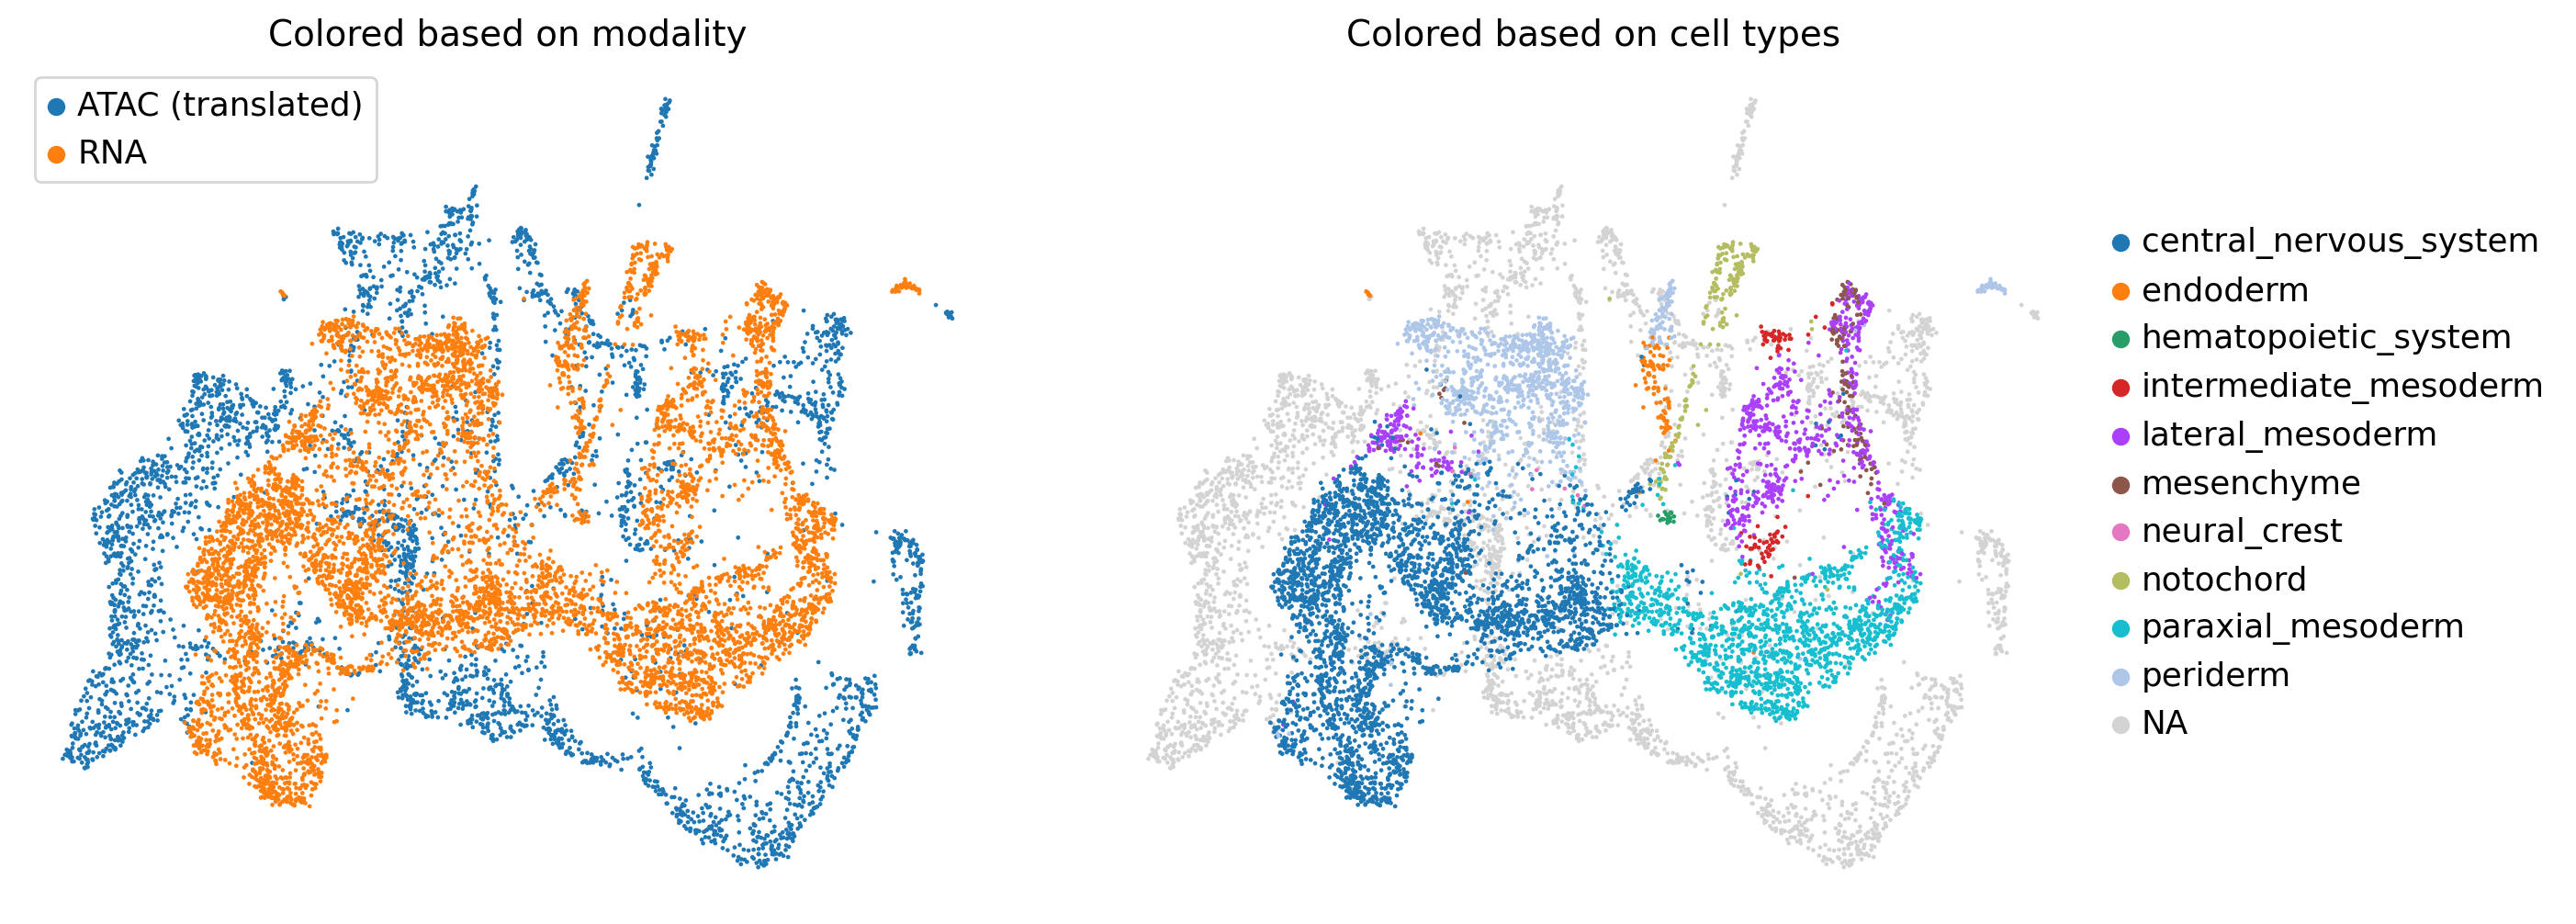

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["zebrafish_anatomy_ontology_class"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

The visualization clearly shows that two datasets are more aligned and harmonized compare to using scVI embeddings that we tried in the previous notebook.

Let's train a Random Forest model on our labels from RNA-seq datasets and transfer them to our ATAC-seq dataset.

In [ ]:
from sklearn.preprocessing import LabelEncoder

latent_rna = rna_seq_data12.obsm['X_pca']
latent_atac = translated
rna_labels = rna_seq_data12.obs['zebrafish_anatomy_ontology_class'].to_numpy()
encoder = LabelEncoder()

# Fit the encoder to the labels
encoded_labels = encoder.fit_transform(rna_labels)

from sklearn.ensemble import RandomForestClassifier

# Train-test split if needed or use all data for training
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(latent_rna, encoded_labels)  # Training on RNA dataset

# Predict labels for the ATAC dataset
predicted_labels = classifier.predict(latent_atac)

print(predicted_labels[:10])

decoded_labels = encoder.inverse_transform(predicted_labels)
print(decoded_labels[:10])



[0 8 0 4 8 0 0 9 0 8]
['central_nervous_system' 'paraxial_mesoderm' 'central_nervous_system'
 'lateral_mesoderm' 'paraxial_mesoderm' 'central_nervous_system'
 'central_nervous_system' 'periderm' 'central_nervous_system'
 'paraxial_mesoderm']


In [ ]:
from collections import Counter



decoded_labels = encoder.inverse_transform(predicted_labels)
print(decoded_labels[:10])

label_counts = Counter(decoded_labels)

# Printing the frequency of each label
for label, count in label_counts.items():
    print(f"{label}: {count}")

['central_nervous_system' 'paraxial_mesoderm' 'central_nervous_system'
 'lateral_mesoderm' 'paraxial_mesoderm' 'central_nervous_system'
 'central_nervous_system' 'periderm' 'central_nervous_system'
 'paraxial_mesoderm']
central_nervous_system: 1711
paraxial_mesoderm: 819
lateral_mesoderm: 468
periderm: 585
mesenchyme: 37
notochord: 111
intermediate_mesoderm: 31
hematopoietic_system: 4
endoderm: 40


In [ ]:
atac_seq_data12.obs['zebrafish_anatomy_ontology_class']

12hpf_2#12hpf_2_BC0017_N01    central_nervous_system
12hpf_2#12hpf_2_BC0018_N01         paraxial_mesoderm
12hpf_2#12hpf_2_BC0027_N01    central_nervous_system
12hpf_2#12hpf_2_BC0039_N02          lateral_mesoderm
12hpf_2#12hpf_2_BC0033_N01         paraxial_mesoderm
                                       ...          
12hpf_3#12hpf_3_BC0985_N01    central_nervous_system
12hpf_3#12hpf_3_BC0957_N01         paraxial_mesoderm
12hpf_3#12hpf_3_BC1010_N01                  periderm
12hpf_3#12hpf_3_BC0931_N01                  periderm
12hpf_3#12hpf_3_BC0979_N01                  periderm
Name: zebrafish_anatomy_ontology_class, Length: 3806, dtype: object

measure the success of integration by looking at each cell type percentage for both datasets and also using FOSCTTM, Jensen-Shannon Divergence, and  cross entropy metrics.

In [ ]:
total_labels = len(decoded_labels)

# Calculating the percentage of each label
label_percentages = {label: (count / total_labels) * 100 for label, count in label_counts.items()}

# Sorting the percentages from high to low
sorted_label_percentages = sorted(label_percentages.items(), key=lambda item: item[1], reverse=True)

# Printing the sorted percentage of each label
for label, percentage in sorted_label_percentages:
    print(f"{label}: {percentage:.2f}%")

central_nervous_system: 44.96%
paraxial_mesoderm: 21.52%
periderm: 15.37%
lateral_mesoderm: 12.30%
notochord: 2.92%
endoderm: 1.05%
mesenchyme: 0.97%
intermediate_mesoderm: 0.81%
hematopoietic_system: 0.11%


In [ ]:
rna_labels = rna_seq_data12.obs['zebrafish_anatomy_ontology_class']

# Calculate the distribution of labels
label_distribution = rna_labels.value_counts(normalize=True)

# Display the label distribution as a percentage
print(label_distribution * 100)



zebrafish_anatomy_ontology_class
central_nervous_system    45.305269
paraxial_mesoderm         20.570234
periderm                  14.434990
lateral_mesoderm          11.628601
notochord                  2.761606
mesenchyme                 2.015226
endoderm                   1.492760
intermediate_mesoderm      1.388267
hematopoietic_system       0.283624
neural_crest               0.119421
Name: proportion, dtype: float64


In [ ]:
import numpy as np
from scipy.special import rel_entr

# Extract and align labels and values from both distributions
labels = sorted(set(label_distribution.index).union(label_percentages.keys()))
distribution_values = np.array([label_distribution.get(label, 0) for label in labels])
percentage_values = np.array([label_percentages.get(label, 0) for label in labels])

# Convert percentage_values from percentages to proportions
percentage_values /= 100

# Normalize to ensure both are probability distributions
distribution_values /= distribution_values.sum()
percentage_values /= percentage_values.sum()

# Calculate Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(rel_entr(p, m)) + np.sum(rel_entr(q, m)))

js_div = jensen_shannon_divergence(distribution_values, percentage_values)
print("Jensen-Shannon Divergence:", js_div)


Jensen-Shannon Divergence: 0.002314891807442606


In [ ]:
import numpy as np

# List of all labels, sorted to ensure consistent order
all_labels = sorted(set(label_distribution.index).union(label_percentages.keys()))

# Create arrays for true and predicted probabilities, filling missing labels with 0
true_probabilities = np.array([label_distribution.get(label, 0) for label in all_labels])
prediction_probabilities = np.array([label_percentages.get(label, 0) for label in all_labels])

# Normalize these arrays to ensure they sum to 1 and convert percentages to probabilities for predictions
true_probabilities /= np.sum(true_probabilities)
prediction_probabilities /= 100  # Convert percentages to probabilities
prediction_probabilities /= np.sum(prediction_probabilities)  # Normalize

# Avoid log(0) issue by adding a small number to prediction probabilities
epsilon = 1e-12
prediction_probabilities = np.clip(prediction_probabilities, epsilon, 1.0 - epsilon)

# Calculate cross-entropy
cross_entropy = -np.sum(true_probabilities * np.log(prediction_probabilities))
print("Cross-Entropy:", cross_entropy)


Cross-Entropy: 1.570495240601228


In [ ]:
import numpy as np
import scipy.spatial

def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    # Compute the pairwise distance matrix between x and y
    d = scipy.spatial.distance_matrix(x, y)

    # Compute self-distance matrices and their medians as thresholds
    d_xx = scipy.spatial.distance_matrix(x, x)
    d_yy = scipy.spatial.distance_matrix(y, y)

    # Using median distance within each set as a threshold might be more robust
    median_xx = np.median(d_xx[d_xx > 0])  # Exclude self-comparisons which are zero
    median_yy = np.median(d_yy[d_yy > 0])  # Same here

    # Calculate how many distances are below these medians
    foscttm_x = (d < median_xx).mean(axis=1)
    foscttm_y = (d.T < median_yy).mean(axis=1)

    # Average of means of these calculations
    mean_x = np.mean(foscttm_x)
    mean_y = np.mean(foscttm_y)
    final_mean = (mean_x + mean_y) / 2

    return final_mean.round(4)


In [ ]:

print(
    "Average FOSCTTM score of translating ATAC onto RNA: ",
    foscttm(rna_seq_data12.obsm["X_pca"], translated),
)

Average FOSCTTM score of translating ATAC onto RNA:  0.5235



The results indicate that overall, the scores are superior compared to those from scVI. Specifically, the Moscot solution predicted the top 5 classes in the correct order, an improvement over the scVI method, which predicted only the top 4. Additionally, the cross-entropy and Shannon divergence scores from the Moscot integration are relatively better than those obtained with the scVI integration. FOSCTTM is also showing a slight improvement compare to what we had in scVI integration.

Note: This is only an estimation of what might be the true labels distribution for other datasets, Further inspection should always be performed.

Nowe can visualize our datasets with their assigned cell type labels.

In [ ]:
atac_seq_data12.obs['zebrafish_anatomy_ontology_class'] = np.array(decoded_labels)


In [ ]:
newdata = sc.concat(
    [atac_seq_data12, rna_seq_data12],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
newdata.obsm["X_translated_1"] = np.concatenate(
    (translated, rna_seq_data12.obsm["X_pca"]), axis=0
)
sc.pp.neighbors(newdata, use_rep="X_translated_1")
sc.tl.umap(newdata)

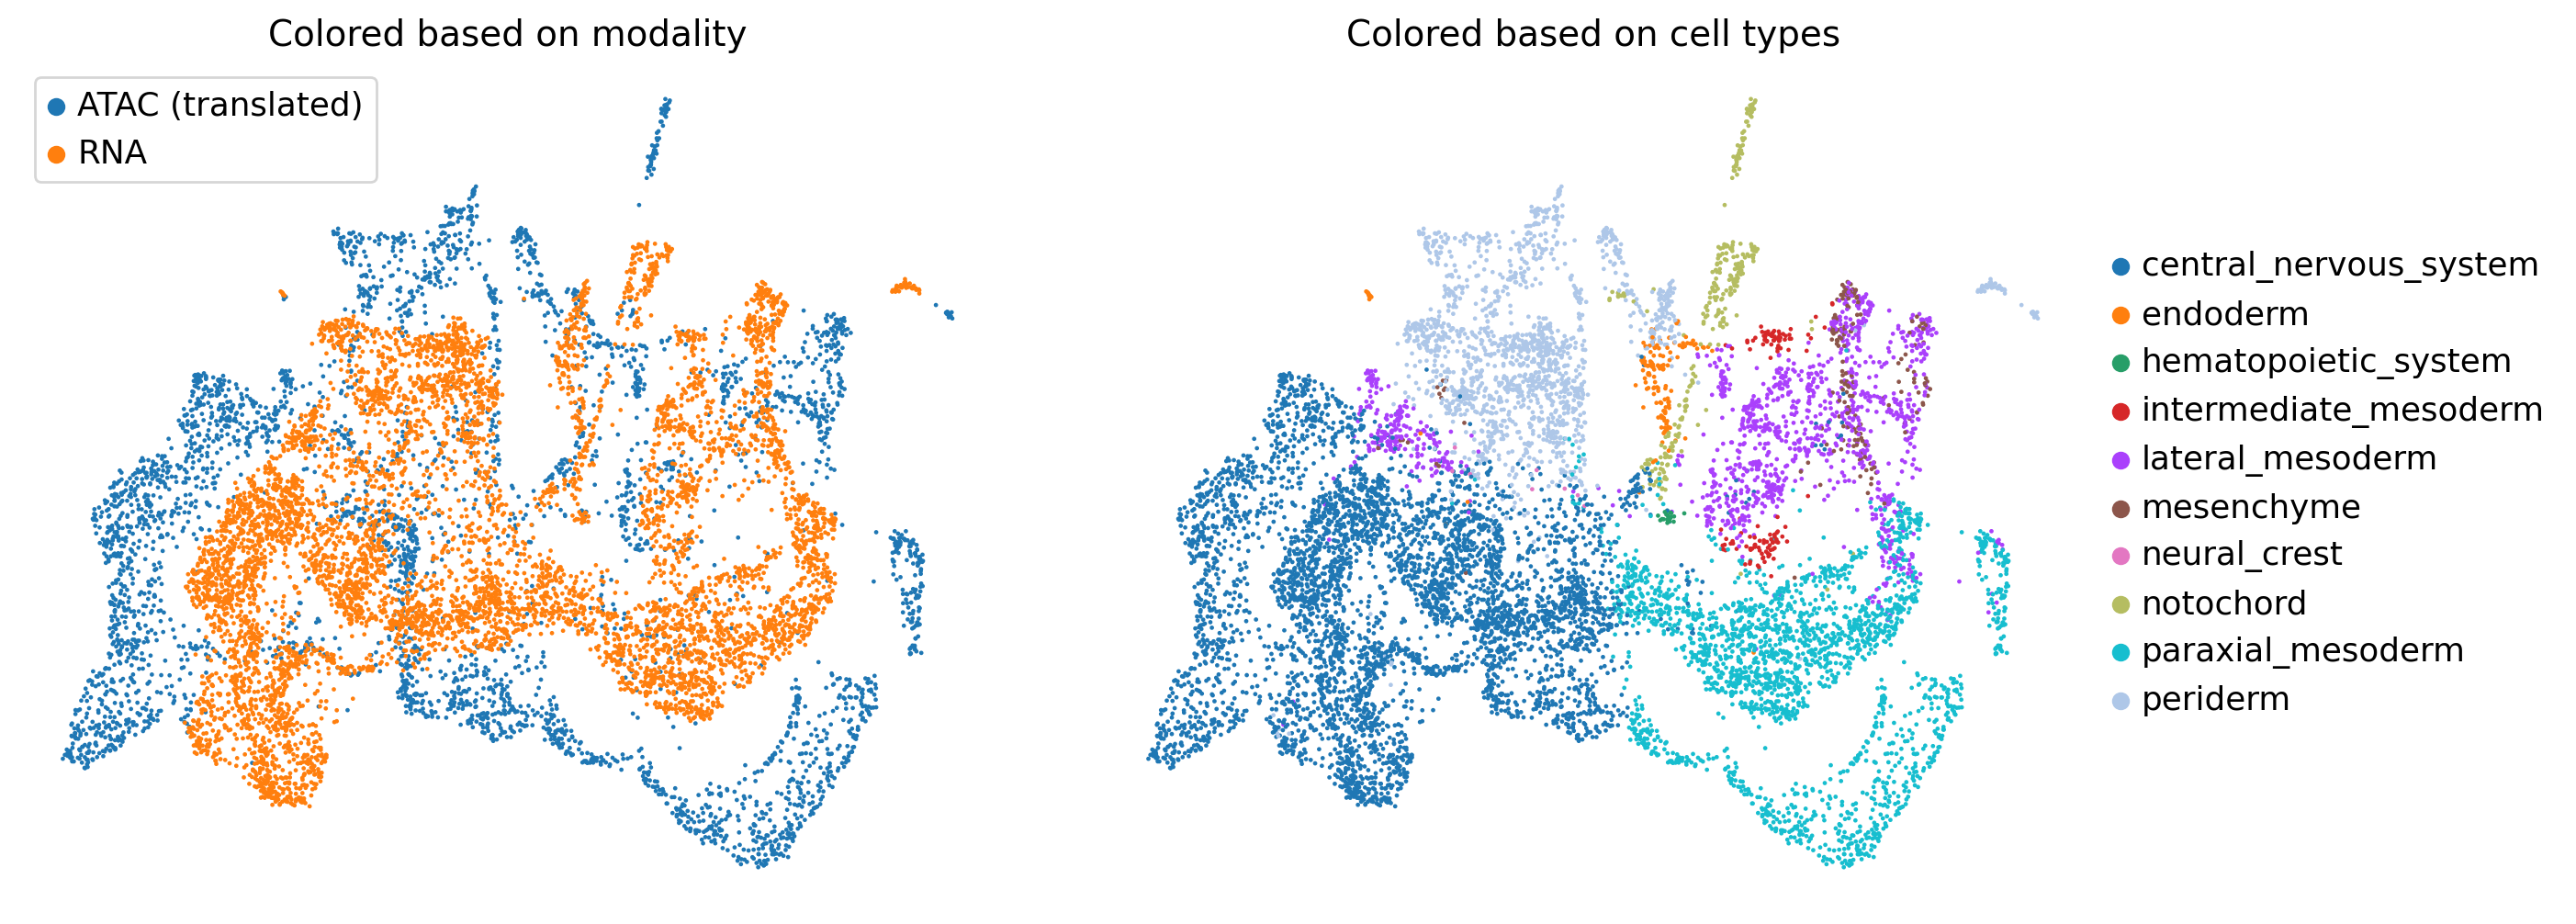

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(newdata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(newdata, color=["zebrafish_anatomy_ontology_class"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()


Looks great! In the next notebook, we will focus on mapping our RNA-seq data to spatially accurate locations using the zebrafish stereo-seq dataset. We will also analyze how cell types communicates and transitions into other types during the developmental stages. You can find the link below: